## Install and Import Dependensies 

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!pip install easyocr
!pip install imutils

In [1]:
import cv2
import imutils
import easyocr
import pytesseract
import numpy as np
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow

## Reading the image

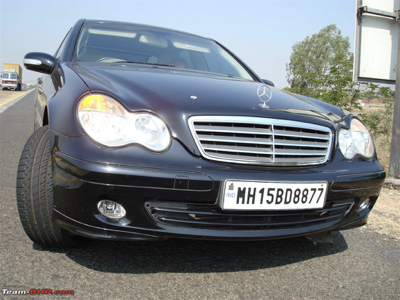

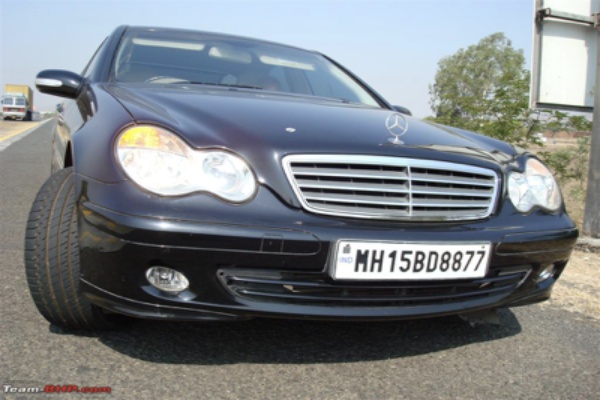

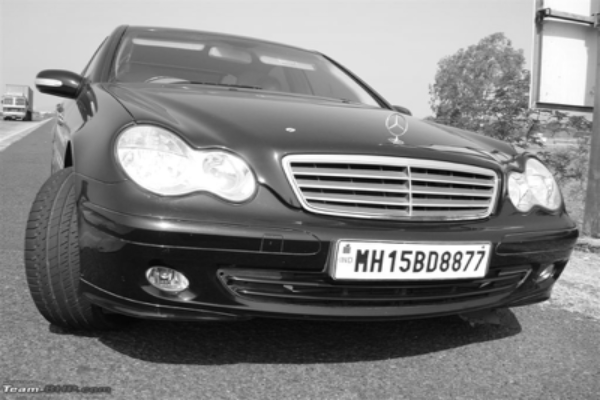

In [343]:
original_image = cv2.imread('/content/drive/MyDrive/car_plates_dataset/Train/Cars39.png')
cv2_imshow(original_image)

resized_image = cv2.resize(original_image,(600, 400))   # change image size into 600*400
cv2_imshow(resized_image)

gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # convert the image into grayscale
cv2_imshow(gray)

# plate detection

### Apply bilater filter for Noise reduction and find edges

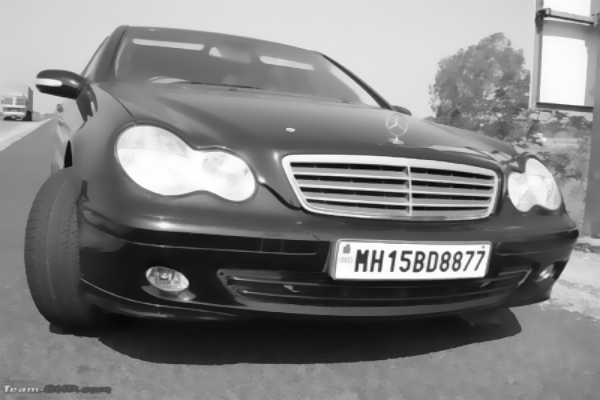

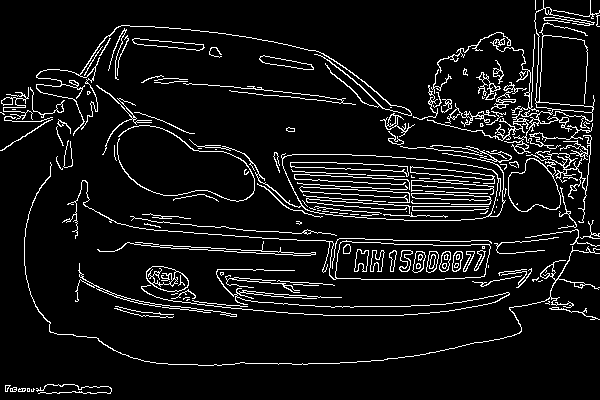

In [344]:
bfilter = cv2.bilateralFilter(gray, 13, 15, 15)  # apply bilateral filter for Noise reduction
cv2_imshow(bfilter)
edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
cv2_imshow(edged)

### Finding contours


In [345]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)

# arrange contours descending based on contour area and get largest 10
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  


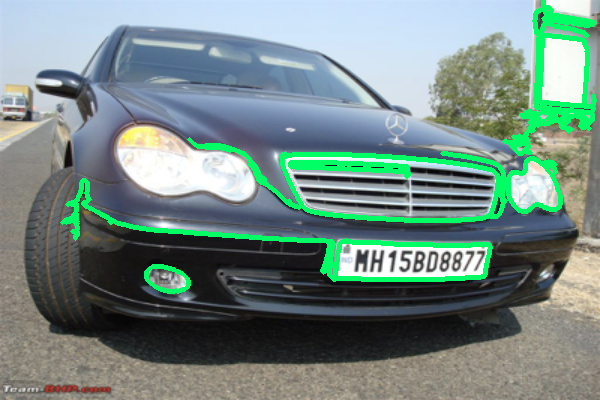

In [346]:
image1 = resized_image.copy()
# drawing the identified contours on our image
cv2.drawContours(image1,contours,-1,(100,255,0),3)
cv2_imshow(image1)

In [347]:
plate_location = None
for contour in contours:
  epsilon =  0.018*cv2.arcLength(contour, True)  # Ratio of contour Perimeter 
  approx = cv2.approxPolyDP(contour, epsilon, True)  # approximate contour shape 
  
  if len(approx) == 4:
    plate_location = approx
    break


In [348]:
plate_location

array([[[335, 276]],

       [[342, 241]],

       [[490, 246]],

       [[480, 277]]], dtype=int32)

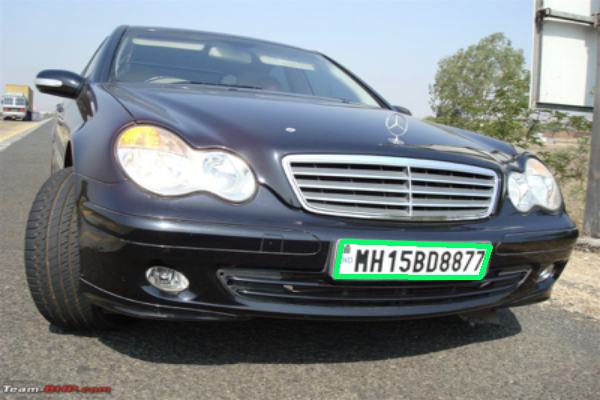

In [349]:
image2 = resized_image.copy()
# drawing the plate contour on our image
cv2.drawContours(image2,[plate_location],-1,(100,255,0),3)
cv2_imshow(image2)

### Masking

In [350]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [plate_location], -1, 255, -1)
new_image = cv2.bitwise_and(resized_image, resized_image, mask=mask)

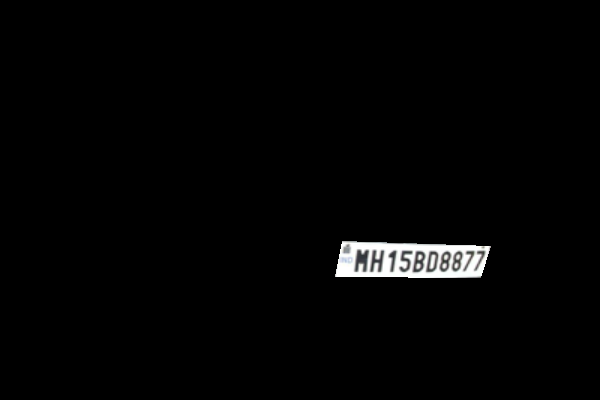

In [351]:
cv2_imshow(new_image)

In [353]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

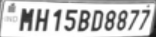

In [354]:
cv2_imshow(cropped_image)

# Apply OCR 

### Use pytessract To Read Text

In [355]:
data = pytesseract.image_to_string(cropped_image, lang='eng', config='--psm 8')
print(data)

“MH15BD8877,



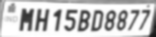

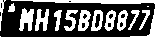

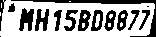

'* MH15BD8877|



In [360]:

blur = cv2.GaussianBlur(cropped_image, (3,3), 0)
cv2_imshow(blur)
thresh = cv2.threshold(cropped_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

# Morph open to remove noise and invert image
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
# cv2_imshow(opening)
invert = 255 - thresh  #opening 
cv2_imshow(invert)

data = pytesseract.image_to_string(invert, lang='eng', config='--psm 8')

print(data)

### Use Easy OCR To Read Text

In [357]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [358]:
text = result[0][-2]
text

'HH15BD8877'